# Which features influence Walmart weekly sales most

This notebook explores [Walmart sales data set](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). The dataset contains weekly sales numbers for 45 stores split by a department. Stores and departments are represented by their numeric IDs. The data set consists of three tables, one containing discounts offered customers during holidays along with the date of the first day of week, a boolean value telling if there was a holiday e.g. Thanksgiving during this week and some additional data such as unemployment rate, temperature, fuel price and Customer Price Index. The second table describes stores and contains data on the size of a store and it's type. The last table contains weekly sales numbers along with the data necessary to join this table with others. This study ignores discounts and explores the most important features only during off-holiday season.

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats.stats import pearsonr

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


%matplotlib inline

/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


## Exploratory data analysis and data cleaning

In [2]:
# Load features and replace date with week number and year
features_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
features_df['Week_Number'] = pd.to_datetime(features_df['Date']).dt.week
features_df['Year'] = pd.to_datetime(features_df['Date']).dt.year
del features_df['Date']
features_df.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Week_Number,Year
0,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5,2010
1,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,6,2010
2,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,7,2010
3,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,8,2010
4,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,9,2010


In [3]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Temperature   8190 non-null   float64
 2   Fuel_Price    8190 non-null   float64
 3   MarkDown1     4032 non-null   float64
 4   MarkDown2     2921 non-null   float64
 5   MarkDown3     3613 non-null   float64
 6   MarkDown4     3464 non-null   float64
 7   MarkDown5     4050 non-null   float64
 8   CPI           7605 non-null   float64
 9   Unemployment  7605 non-null   float64
 10  IsHoliday     8190 non-null   bool   
 11  Week_Number   8190 non-null   int64  
 12  Year          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(3)
memory usage: 775.9 KB


In [4]:
# Drop markdown columns that contain a lot of missing values. These features will not be considered in this study.
features_df = features_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)
features_df.head()
# Drop duplicate column
del features_df['IsHoliday']
features_df = features_df.drop_duplicates()

In [5]:
# Replace missing numeric features with mean values.
simple_imputer = SimpleImputer(strategy='mean')
float_data = features_df.select_dtypes(include='float')
columns = float_data.columns
features_df[columns] = simple_imputer.fit_transform(float_data)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Temperature   8190 non-null   float64
 2   Fuel_Price    8190 non-null   float64
 3   CPI           8190 non-null   float64
 4   Unemployment  8190 non-null   float64
 5   Week_Number   8190 non-null   int64  
 6   Year          8190 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 511.9 KB


In [6]:
# Read stores data.
stores_df = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv', index_col='Store')
stores_df.head()

,Type,Size
Store,,
1,A,151315
2,A,202307
3,B,37392
4,A,205863
5,B,34875


In [7]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Type    45 non-null     object
 1   Size    45 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [8]:
# Merge stores data with features.
stores_features_df = pd.merge(left=features_df, right=stores_df, how='left', left_on='Store', right_index=True)
stores_features_df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,Week_Number,Year,Type,Size
0,1,42.31,2.572,211.096358,8.106,5,2010,A,151315
1,1,38.51,2.548,211.242170,8.106,6,2010,A,151315
2,1,39.93,2.514,211.289143,8.106,7,2010,A,151315
3,1,46.63,2.561,211.319643,8.106,8,2010,A,151315
4,1,46.50,2.625,211.350143,8.106,9,2010,A,151315


In [9]:
stores_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Temperature   8190 non-null   float64
 2   Fuel_Price    8190 non-null   float64
 3   CPI           8190 non-null   float64
 4   Unemployment  8190 non-null   float64
 5   Week_Number   8190 non-null   int64  
 6   Year          8190 non-null   int64  
 7   Type          8190 non-null   object 
 8   Size          8190 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 639.8+ KB


In [10]:
# Read sales data.
train_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [12]:
# Replace date with the number of week and year.
train_df['Week_Number'] = pd.to_datetime(train_df['Date']).dt.week
train_df['Year'] = pd.to_datetime(train_df['Date']).dt.year
del train_df['Date']
train_df = train_df.drop_duplicates()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
 4   Week_Number   421570 non-null  int64  
 5   Year          421570 non-null  int64  
dtypes: bool(1), float64(1), int64(4)
memory usage: 19.7 MB


In [13]:
train_df = train_df.set_index(['Store', 'Week_Number', 'Year'])
stores_features_df = stores_features_df.set_index(['Store', 'Week_Number', 'Year'])

In [14]:
# Merge sales data with features and stores data.
data = pd.merge(left=train_df, right=stores_features_df, on=['Store', 'Week_Number', 'Year'], validate='m:1')
data = data.reset_index()
data.head()

,Store,Week_Number,Year,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,5,2010,1,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,5,2010,2,50605.27,False,42.31,2.572,211.096358,8.106,A,151315
2,1,5,2010,3,13740.12,False,42.31,2.572,211.096358,8.106,A,151315
3,1,5,2010,4,39954.04,False,42.31,2.572,211.096358,8.106,A,151315
4,1,5,2010,5,32229.38,False,42.31,2.572,211.096358,8.106,A,151315


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Week_Number   421570 non-null  int64  
 2   Year          421570 non-null  int64  
 3   Dept          421570 non-null  int64  
 4   Weekly_Sales  421570 non-null  float64
 5   IsHoliday     421570 non-null  bool   
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   CPI           421570 non-null  float64
 9   Unemployment  421570 non-null  float64
 10  Type          421570 non-null  object 
 11  Size          421570 non-null  int64  
dtypes: bool(1), float64(5), int64(5), object(1)
memory usage: 35.8+ MB


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Week_Number,421570.0,25.826762,14.151887,1.000,14.000000,26.00000,38.000000,52.000000
Year,421570.0,2010.968591,0.796876,2010.000,2010.000000,2011.00000,2012.000000,2012.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
CPI,421570.0,171.201947,39.159276,126.064,132.022667,182.31878,212.416993,227.232807
Unemployment,421570.0,7.960289,1.863296,3.879,6.891000,7.86600,8.572000,14.313000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000


In [17]:
# Remove rows with negative sales
data = data[data['Weekly_Sales'] >= 0]

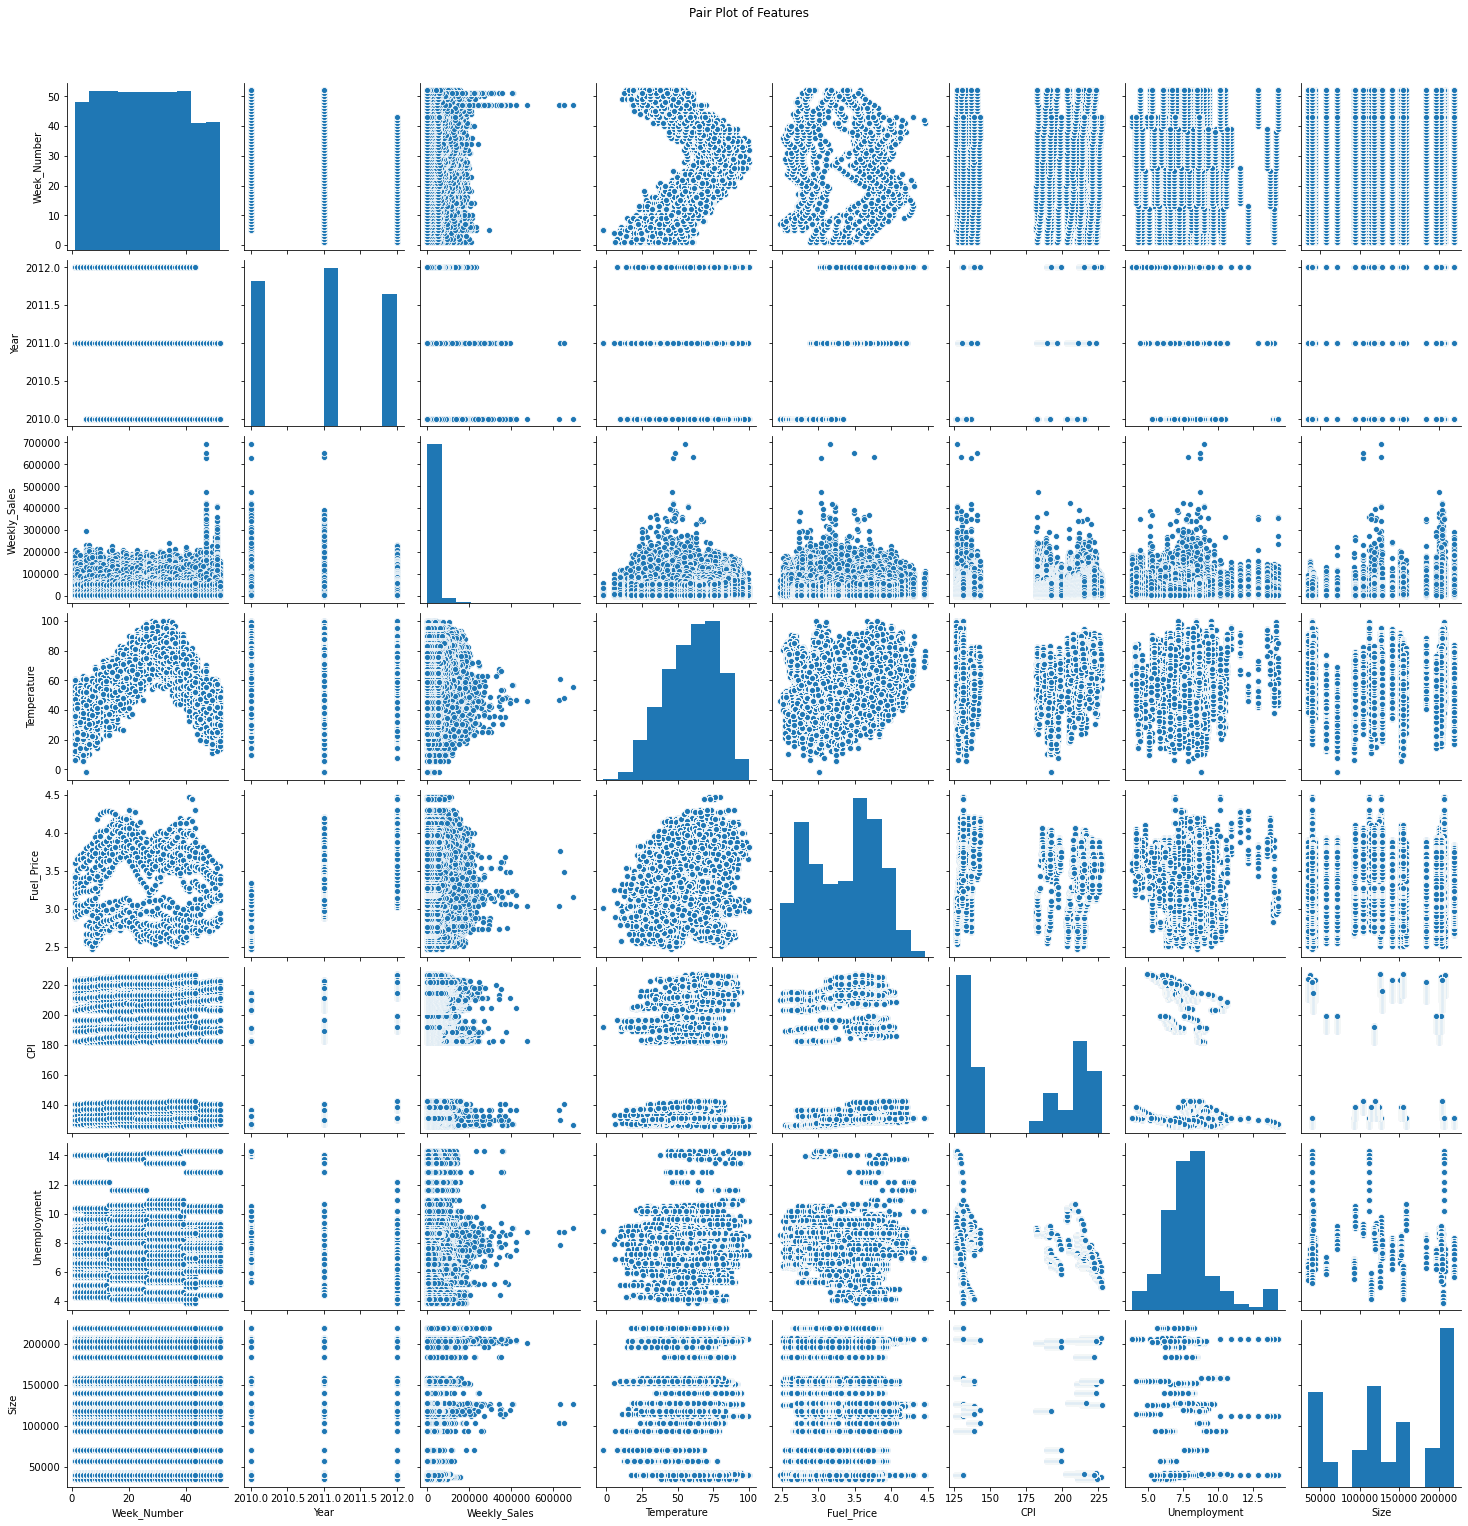

In [18]:
# Create a pair plot for numeric data columns except the IDs of stores and departments as these are some random numbers.
my_data = data.select_dtypes(include=['float', 'int']).drop(['Store', 'Dept'], axis=1)
my_plot = sns.pairplot(my_data)
my_plot.fig.suptitle('Pair Plot of Features', y=1.05)
plt.show()

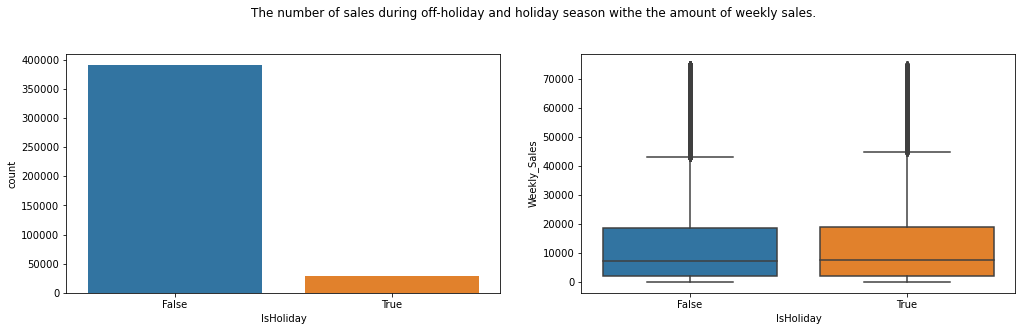

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))
fig.tight_layout(pad=5)
sns.countplot(data=data, x='IsHoliday', ax=ax1)
sns.boxplot(x=data['IsHoliday'], y=data[data['Weekly_Sales'] < 75000]['Weekly_Sales'], ax=ax2)
fig.suptitle('The number of sales during off-holiday and holiday season withe the amount of weekly sales.')
fig.show()

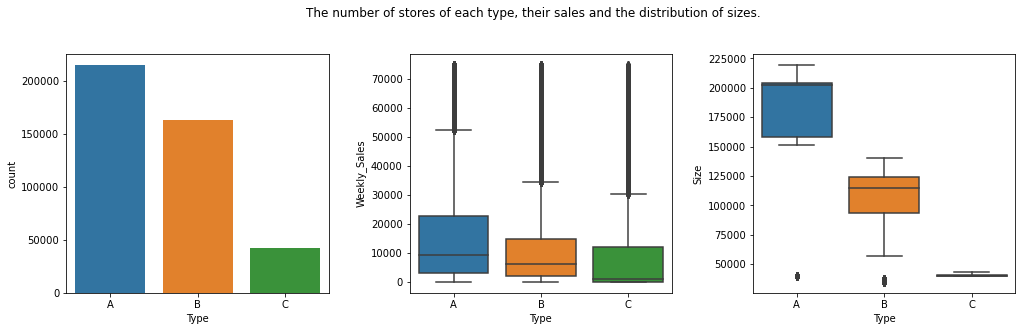

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, figsize=(15, 5))
fig.tight_layout(pad=5)
sns.countplot(data=data, x='Type', ax=ax1)
sns.boxplot(x=data['Type'], y=data[data['Weekly_Sales'] < 75000]['Weekly_Sales'], ax=ax2)
sns.boxplot(x=data['Type'], y=data['Size'], ax=ax3)
fig.suptitle('The number of stores of each type, their sales and the distribution of sizes.')
fig.show()

In [21]:
# Misclassified stores IDs
data[((data['Type'] == 'A') | (data['Type'] == 'B')) & (data['Size'] < 50000)]['Store'].unique()

array([ 3,  5, 33, 36])

## The analysis of correlation between featues

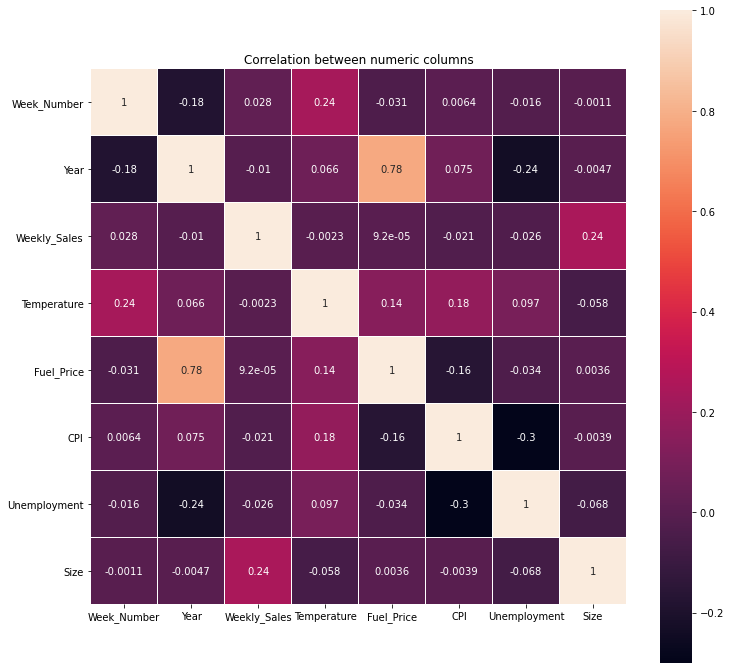

In [22]:
# Correlation between numeric columns
plt.figure(figsize=(12, 12))
plt.title("Correlation between numeric columns")
sns.heatmap(my_data.corr(), square=True, annot=True, linewidths=0.1)
plt.show()

In [23]:
# Pearson correlation coefficient and p-value for weekly sales and store size
pearsonr(data['Weekly_Sales'], data['Size'])

(0.24408906891979357, 0.0)

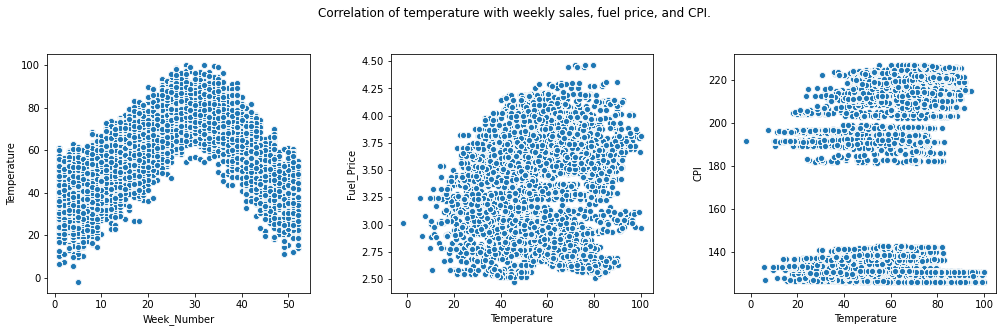

In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
fig.tight_layout(pad=5)
sns.scatterplot(x=data['Week_Number'], y=data['Temperature'], ax=axs[0])
sns.scatterplot(x=data['Temperature'], y=data['Fuel_Price'], ax=axs[1])
sns.scatterplot(x=data['Temperature'], y=data['CPI'], ax=axs[2])
fig.suptitle('Correlation of temperature with weekly sales, fuel price, and CPI.')
fig.show()

In [25]:
pearsonr(data['Temperature'], data['Fuel_Price']), pearsonr(data['Temperature'], data['CPI'])

((0.1437183136432649, 0.0), (0.1821912325888075, 0.0))

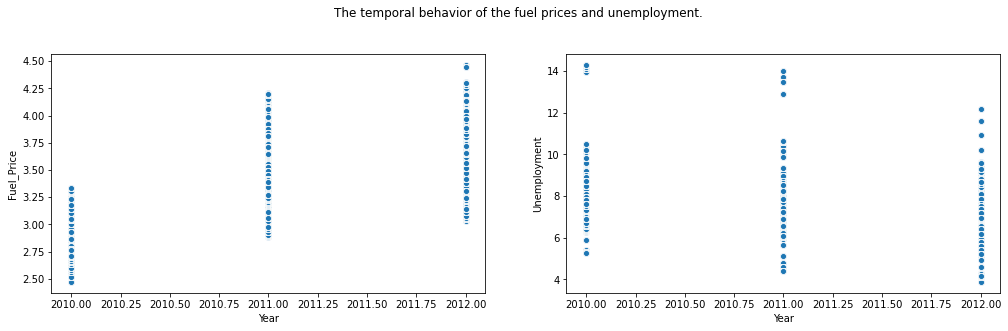

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
fig.tight_layout(pad=5)
sns.scatterplot(x=data['Year'], y=data['Fuel_Price'], ax=axs[0])
sns.scatterplot(x=data['Year'], y=data['Unemployment'], ax=axs[1])
fig.suptitle('The temporal behavior of the fuel prices and unemployment.')
fig.show()

In [27]:
# Correlation and p-values for the values depicted above
pearsonr(data['Year'], data['Fuel_Price']), pearsonr(data['Year'], data['Unemployment'])

((0.779672564858295, 0.0), (-0.23721035748732944, 0.0))

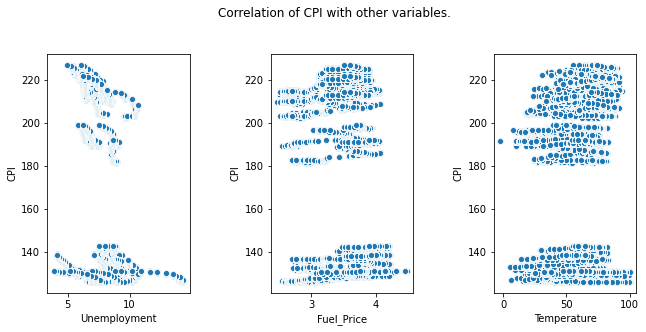

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
fig.tight_layout(pad=5)
sns.scatterplot(x=data['Unemployment'], y=data['CPI'], ax=axs[0])
sns.scatterplot(x=data['Fuel_Price'], y=data['CPI'], ax=axs[1])
sns.scatterplot(x=data['Temperature'], y=data['CPI'], ax=axs[2])
fig.suptitle('Correlation of CPI with other variables.')
fig.show()

In [29]:
# Correlation and p-values for the values depicted above
pearsonr(data['CPI'], data['Unemployment']), pearsonr(data['CPI'], data['Fuel_Price']), pearsonr(data['CPI'], data['Temperature'])

((-0.2999019481380698, 0.0),
 (-0.16420724701538375, 0.0),
 (0.1821912325888075, 0.0))

## Feature importances and forecast precision using Random Forest model

In [30]:
def plot_feature_importances(random_forest_regressor, feature_names):
    """Plots the importance of features
    :param: random_forest_regressor - a train random forest regressor
    :param: feature_names - a list of feature names
    """
    feature_importances = (pd.DataFrame({"importance": random_forest_regressor.feature_importances_,
                                       "feature": feature_names}).sort_values(by=['importance'],
                                                                                 ascending=False))
    feature_importances
    sns.barplot(x="importance", y="feature", data=feature_importances,
            label="Feature Importance", color="b")
    plt.title('Feature importances')
    plt.show()

In [31]:
# Select data only for weeks that do not contain holydays and create random forest regressor
off_holiday_data = data[data['IsHoliday'] == False]
regressor = RandomForestRegressor(random_state=1)

In [32]:
# Train random forest on all numeric features
features = ['Store', 'Week_Number', 'Year', 'Dept', 'Temperature',
            'Fuel_Price', 'CPI', 'Unemployment', 'Size']
X = off_holiday_data[features]
y = off_holiday_data['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [33]:
# Estimate forecast precision for all numeric features
y_actual = regressor.predict(X_test)
mean_absolute_error(y_test, y_actual)

1384.3584494517868

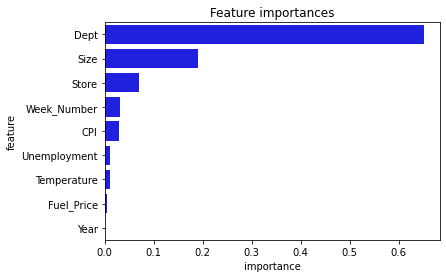

In [34]:
# Plot feature importances for all numeric features
plot_feature_importances(regressor, features)

In [35]:
# Train random forest on selected features
features = ['Store', 'Week_Number', 'Year', 'Dept', 'Size']
X = off_holiday_data[features]
y = off_holiday_data['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [36]:
# Estimate forecast precision for selected features
y_actual = regressor.predict(X_test)
mean_absolute_error(y_test, y_actual)

1324.956458384947

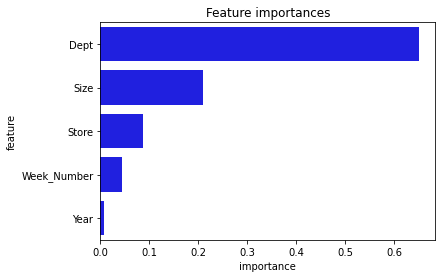

In [37]:
# Plot feature importances for selected features
plot_feature_importances(regressor, features)

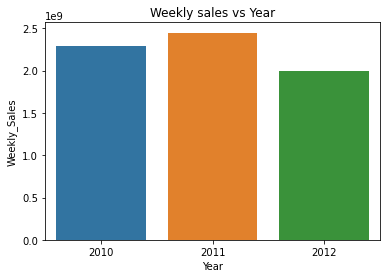

In [38]:
# How Weekly sales change with a year
tmp = data[['Year', 'Weekly_Sales']].groupby('Year', as_index=False).sum()
sns.barplot(x='Year', y='Weekly_Sales', data=tmp)
plt.title('Weekly sales vs Year')
plt.show()

In [39]:
# The estimate of relative change in sales over one year
(tmp.loc[1, 'Weekly_Sales'] - tmp.loc[2, 'Weekly_Sales']) / tmp.loc[2, 'Weekly_Sales']

0.22402105752691048